<a href="https://colab.research.google.com/github/hyd3nekosuki/RPDsummer2024/blob/main/1DSlabDiffusion2024RPDsmr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
from numba import njit

In [2]:
def calcMatrixA(D, Dcor, SigA, dx, matid, albedo):
    NX  = len(s)
    A = sp.lil_matrix((NX, NX))

    for i in range(NX):
        D0  = D[i]
        dx0 = dx[i]
        if i==0:
            a = albedo[0]
            Dxm = -(1-a)*D0/(2*(1+a)*D0 + (1-a)*dx0/2)
        else:
            Dm  = D[i-1]
            dxm = dx[i-1]
            Dxm = -2*Dm*D0/(Dm*dx0 + D0*dxm)
            Axm = (Dxm-Dcor[i])/dx0
            A[i,i-1] = Axm
        if i==(NX-1):
            a = albedo[1]
            Dxp = -(1-a)*D0/(2*(1+a)*D0 + (1-a)*dx0/2)
        else:
            Dp  = D[i+1]
            dxp = dx[i+1]
            Dxp = -2*D0*Dp/(D0*dxp + Dp*dx0)
            A[i,i+1] = (Dxp+Dcor[i+1])/dx0

        A[i,i] = SigA[matid[i]] - ( (Dxm+Dcor[i] + Dxp-Dcor[i+1])/dx0 )

    A = A.tocsr()
    return A


@njit(cache=True)
def diffusion1DX(D, Dcor, SigA, s, dx, matid, albedo):
    NX  = len(s)
    L   = np.zeros(NX)
    U   = np.zeros(NX)
    Axp = np.zeros(NX)

    for i in range(NX):
        D0  = D[i]
        dx0 = dx[i]
        if i==0:
            a = albedo[0]
            Dxm = -(1-a)*D0/(2*(1+a)*D0 + (1-a)*dx0/2)
        else:
            Dm  = D[i-1]
            dxm = dx[i-1]
            Dxm = -2*Dm*D0/(Dm*dx0 + D0*dxm)
            Axm = (Dxm-Dcor[i])/dx0
        if i==(NX-1):
            a = albedo[1]
            Dxp = -(1-a)*D0/(2*(1+a)*D0 + (1-a)*dx0/2)
        else:
            Dp  = D[i+1]
            dxp = dx[i+1]
            Dxp = -2*D0*Dp/(D0*dxp + Dp*dx0)
            Axp[i] = (Dxp+Dcor[i+1])/dx0

        A0 = SigA[matid[i]] - ( (Dxm+Dcor[i] + Dxp-Dcor[i+1])/dx0 )

        if i==0:
            L[i] = 0.0
            U[i] = A0
        else:
            L[i] = Axm/U[i-1]
            U[i] = A0 - Axp[i-1]*L[i]

    B = np.zeros(NX)
    BBefore = 0.0
    for i in range(NX):
        B[i] = s[i] - BBefore*L[i]
        BBefore = B[i]

    flux = np.zeros(NX)
    fluxAfter = 0.0
    for i in range(NX-1, -1, -1):
        fluxAfter = (B[i] - Axp[i]*fluxAfter) / U[i]
        flux[i] = fluxAfter

    return flux

In [3]:
@njit(cache=True)
def calcFluxDiffusion(SigS, SigA, s, dx, matid, albedo):
    NX = len(s)
    SigT = SigA+SigS
    D = 1/(3*SigT)
    Dcor = np.zeros(NX+1)
    flux = diffusion1DX(D[matid], Dcor, SigA, s, dx, matid, albedo)
    return flux

In [4]:
def ordinal(i):
    j = i%100
    return "{}".format(i)+({1:"st", 2:"nd", 3:"rd"}.get(j if 14>j>10 else j % 10) or "th")

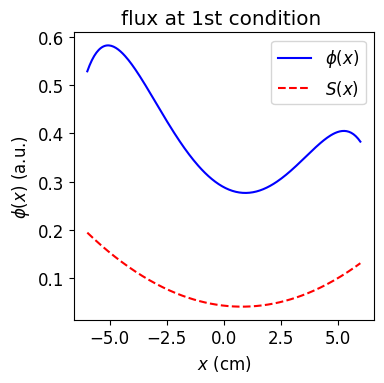

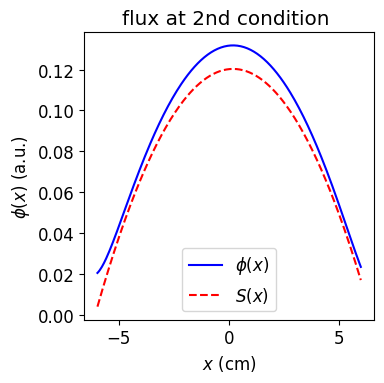

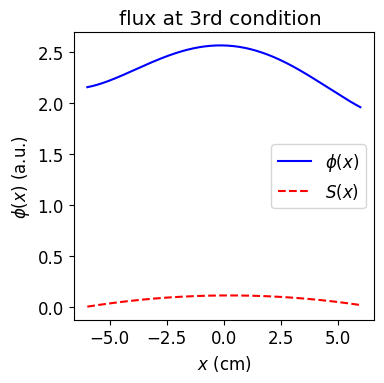

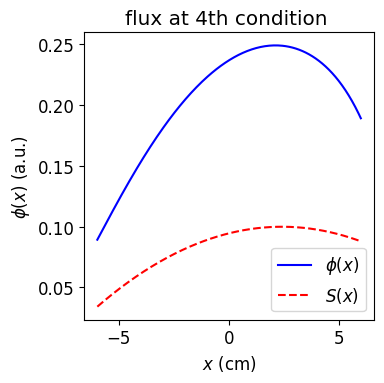

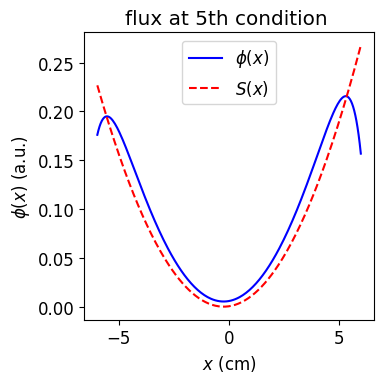

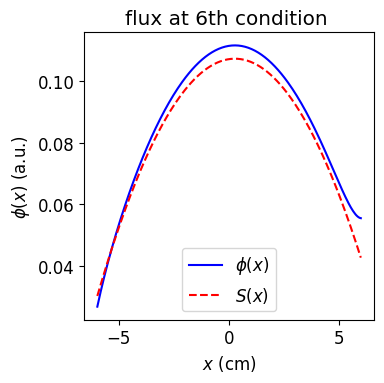

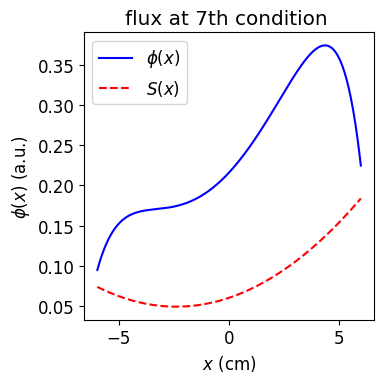

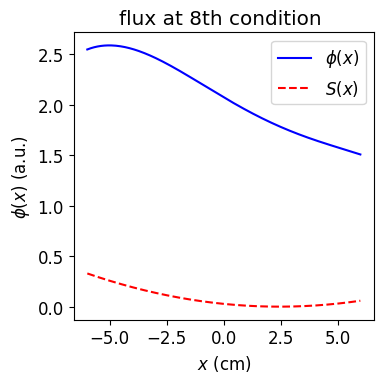

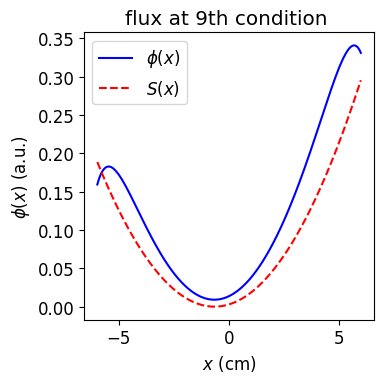

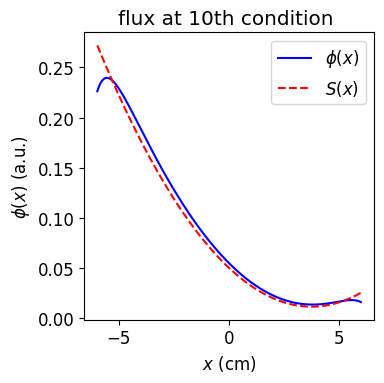

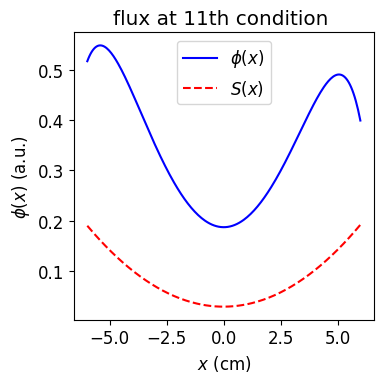

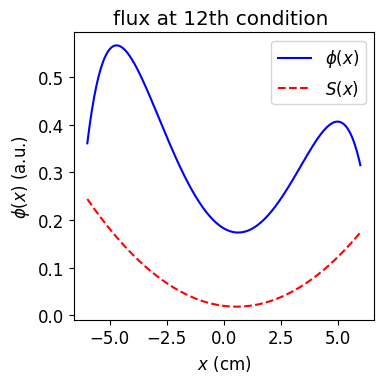

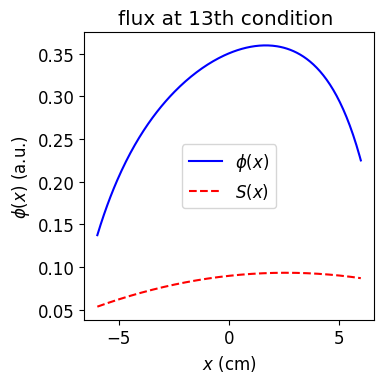

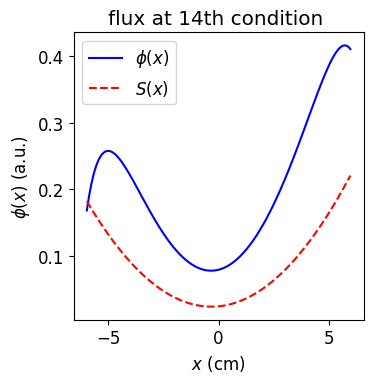

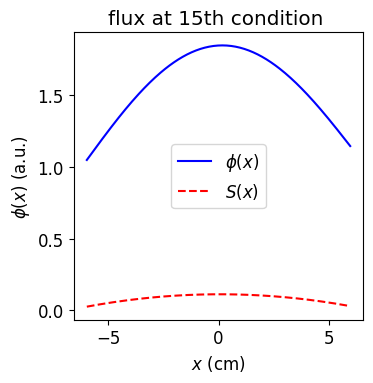

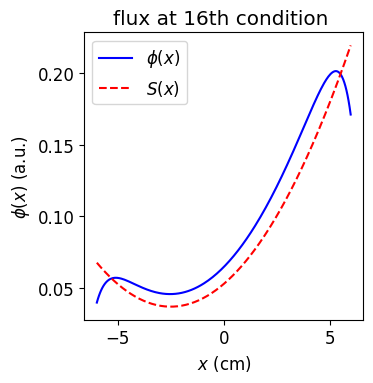

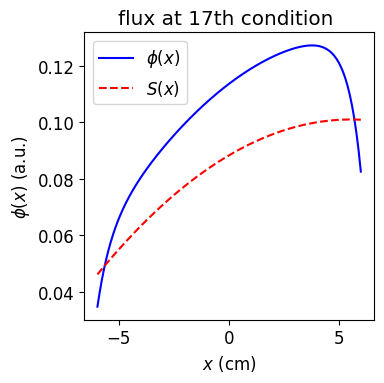

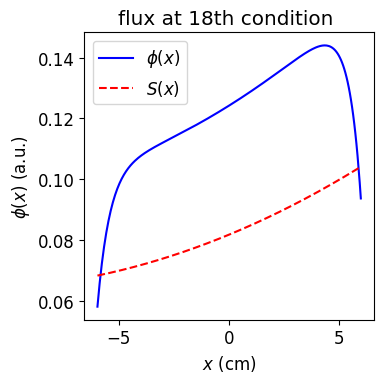

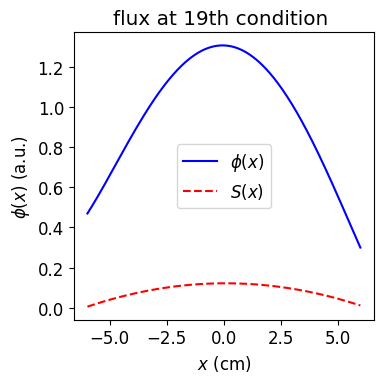

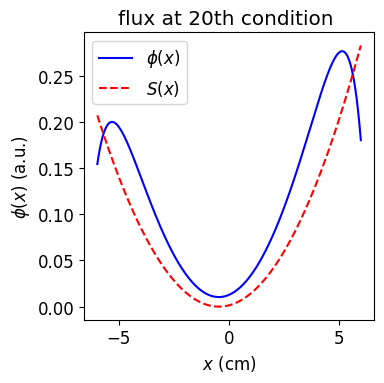

In [5]:
outermax = 1000
eps = 1e-12
np.random.seed(20240619)

LengthX = 12.0
NX = 240
dx = np.full( NX, LengthX/NX )
xS = np.linspace(start=-LengthX/2, stop=LengthX/2, num=NX+1)
x = (xS[:-1] + xS[1:])/2

matid = np.zeros(NX, dtype=np.int64)
NC = 20
snapshotF = np.zeros( (NX,NC) )
snapshotQ = np.zeros( (NX,NC) )

plt.rcParams["figure.figsize"]=(4,4)
plt.rcParams["font.size"] = 12

for i in range(NC):
    SigA = np.random.uniform(low=0.01, high=1.0, size=(1))
    SigS = np.random.uniform(low=0.01, high=1.0, size=(1))

    s = np.zeros(NX)
    xi = np.random.uniform(low=-1.0, high=1.0)
    y = np.random.uniform(low=0.0, high=1.0, size=3)
    a = y[0]/(2*(1+xi)) +y[1]/(xi*xi-1) + y[2]/(2*(1-xi))
    b = (y[2]-y[0])/2
    c = xi*( y[0]/(2*(1+xi)) -y[2]/(2*(1-xi)) )  -y[1]/(xi*xi-1)
    vx = -b/(2*a)
    if vx>=-1 and vx<=1:
        vy = a*vx**2 + b*vx + c
        if vy <0:
            c = c-vy
            vy = vy = a*vx**2 + b*vx + c
            c = c-vy
    stotal = ((a/3)+c)*LengthX
    a = a/stotal
    b = b/stotal
    c = c/stotal

    s = a*(x/(LengthX/2))**2 + b*(x/(LengthX/2)) + c
    if s.min() < 0:
        print("Warning: source is negative")

    albedo = np.random.uniform(low=0.0, high=1.0, size=(2))
    flux = calcFluxDiffusion(SigS, SigA, s, dx, matid, albedo)
    snapshotF[:,i] = flux
    snapshotQ[:,i] = (s + SigS[matid]*flux)

    #if i>=10:
    #    continue

    plt.plot(x, flux, color="blue", linestyle="solid", label="$\phi(x)$")
    plt.plot(x, s, color="red", linestyle="dashed", label="$S(x)$")
    plt.title("flux at {} condition ".format(ordinal(i+1)))
    fluxmax = flux.max()
    #plt.ylim((0, fluxmax*1.1))
    plt.xlabel("$x$ (cm)")
    plt.ylabel("$\phi(x)$ (a.u.)")
    plt.legend()
    plt.tight_layout()
    plt.show()